In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
import os

In [2]:
df = pd.read_csv(r'C:\Users\ompat\OneDrive\Desktop\mini_proj_data\processed_data.csv')
df

,lesion_id,image_id,dx,dx_type,age,sex,localization,image_path,label_id,is_malignant,clean_path,variant
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,C:\Users\ompat\OneDrive\Desktop\mini_proj_data...,2,0,C:/Users/ompat/OneDrive/Desktop/mini_proj_data...,clean
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,C:\Users\ompat\OneDrive\Desktop\mini_proj_data...,2,0,C:/Users/ompat/OneDrive/Desktop/mini_proj_data...,clean
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,C:\Users\ompat\OneDrive\Desktop\mini_proj_data...,2,0,C:/Users/ompat/OneDrive/Desktop/mini_proj_data...,clean
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,C:\Users\ompat\OneDrive\Desktop\mini_proj_data...,2,0,C:/Users/ompat/OneDrive/Desktop/mini_proj_data...,clean
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,C:\Users\ompat\OneDrive\Desktop\mini_proj_data...,2,0,C:/Users/ompat/OneDrive/Desktop/mini_proj_data...,clean
...,...,...,...,...,...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,C:\Users\ompat\OneDrive\Desktop\mini_proj_data...,0,1,C:/Users/ompat/OneDrive/Desktop/mini_proj_data...,clean
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,C:\Users\ompat\OneDrive\Desktop\mini_proj_data...,0,1,C:/Users/ompat/OneDrive/Desktop/mini_proj_data...,clean
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,C:\Users\ompat\OneDrive\Desktop\mini_proj_data...,0,1,C:/Users/ompat/OneDrive/Desktop/mini_proj_data...,clean
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,C:\Users\ompat\OneDrive\Desktop\mini_proj_data...,0,1,C:/Users/ompat/OneDrive/Desktop/mini_proj_data...,clean


In [3]:
df.columns

Index(['lesion_id', 'image_id', 'dx', 'dx_type', 'age', 'sex', 'localization',
       'image_path', 'label_id', 'is_malignant', 'clean_path', 'variant'],
      dtype='object')

# 1. With Processed Images 

In [4]:
X = df['clean_path']   # paths to images

In [5]:
import cv2
import numpy as np

def load_and_preprocess_image(path, target_size=(224,224)):
    img = cv2.imread(path)                      # read image
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  
    img = cv2.resize(img, target_size)
    img = img / 255.0                           # normalize to [0,1]
    return img.astype('float32')


X_images=np.array([load_and_preprocess_image(p) for p in X])

# --- Standardization step (per-channel) ---
mean = np.mean(X_images, axis=(0,1,2), keepdims=True)
std  = np.std(X_images, axis=(0,1,2), keepdims=True)

X_images = (X_images - mean) / (std + 1e-7)


In [6]:
X_images

array([[[[ 3.4443824 ,  2.6502833 ,  3.5302312 ],
         [ 3.659004  ,  2.8649046 ,  3.7448525 ],
         [ 3.6804662 ,  2.8863668 ,  3.809239  ],
         ...,
         [ 3.8736255 ,  2.9936776 ,  3.2941475 ],
         [ 3.9165497 ,  3.0366018 ,  3.4229205 ],
         [ 4.088247  ,  3.208299  ,  3.5946176 ]],

        [[ 3.4658446 ,  2.6502833 ,  3.5302312 ],
         [ 3.7233903 ,  2.929291  ,  3.809239  ],
         [ 3.8521633 ,  3.058064  ,  3.980936  ],
         ...,
         [ 3.8521633 ,  2.9722154 ,  3.2726853 ],
         [ 4.152633  ,  3.2726853 ,  3.6160798 ],
         [ 4.0453224 ,  3.1653748 ,  3.508769  ]],

        [[ 3.5516932 ,  2.6717453 ,  3.5302312 ],
         [ 3.6375418 ,  2.8219805 ,  3.659004  ],
         [ 3.7019284 ,  2.8863668 ,  3.7663147 ],
         ...,
         [ 3.8521633 ,  2.9507532 ,  3.208299  ],
         [ 4.109709  ,  3.208299  ,  3.4658446 ],
         [ 3.959474  ,  3.058064  ,  3.3585339 ]],

        ...,

        [[ 2.2425025 ,  1.5342516 ,  2

In [7]:
from tensorflow.keras import Model, regularizers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Flatten, Dropout, Input
import tensorflow as tf

# ---------------- CNN1 ----------------
def build_cnn1(input_shape):
    inputs = Input(shape=input_shape)

    x = Conv2D(32, (3,3), activation='relu', padding="same",
               kernel_regularizer=regularizers.l2(1e-4))(inputs)
    x = MaxPooling2D((2,2))(x)

    x = Conv2D(64, (3,3), activation='relu', padding="same",
               kernel_regularizer=regularizers.l2(1e-4))(x)
    x = MaxPooling2D((2,2))(x)

    x = Conv2D(128, (3,3), activation='relu', padding="same",
               kernel_regularizer=regularizers.l2(1e-4))(x)
    x = MaxPooling2D((2,2))(x)

    x = Conv2D(256, (3,3), activation='relu', padding="same",
               kernel_regularizer=regularizers.l2(1e-4))(x)
    x = MaxPooling2D((2,2))(x)
    
    x = Flatten()(x)
    x = Dropout(0.5)(x)   # still useful to avoid overfitting
    return Model(inputs, x, name="CNN1")

# ---------------- CNN2 ----------------
def build_cnn2(input_shape):
    inputs = Input(shape=input_shape)

    x = Conv2D(256, (7,7), activation='relu', padding="same",
               kernel_regularizer=regularizers.l2(1e-4))(inputs)
    x = AveragePooling2D((2,2))(x)

    x = Conv2D(128, (5,5), activation='relu', padding="same",
               kernel_regularizer=regularizers.l2(1e-4))(x)
    x = AveragePooling2D((2,2))(x)

    x = Conv2D(96, (3,3), activation='relu', padding="same",
               kernel_regularizer=regularizers.l2(1e-4))(x)
    x = AveragePooling2D((2,2))(x)

    x = Conv2D(96, (3,3), activation='relu', padding="same",
               kernel_regularizer=regularizers.l2(1e-4))(x)
    x = AveragePooling2D((2,2))(x)

    x = Flatten()(x)
    x = Dropout(0.5)(x)
    return Model(inputs, x, name="CNN2")

# ---------------- CNN3 ----------------
def build_cnn3(input_shape):
    inputs = Input(shape=input_shape)

    x = Conv2D(32, (3,3), activation='relu', padding="same",
               kernel_regularizer=regularizers.l2(1e-4))(inputs)
    x = MaxPooling2D((2,2))(x)

    x = Conv2D(96, (5,5), activation='relu', padding="same",
               kernel_regularizer=regularizers.l2(1e-4))(x)
    x = MaxPooling2D((2,2))(x)

    x = Conv2D(128, (5, 5), activation='relu', padding="same",
               kernel_regularizer=regularizers.l2(1e-4))(x)
    x = MaxPooling2D((2,2))(x)

    x = Conv2D(256, (7, 7), activation='relu', padding="same",
               kernel_regularizer=regularizers.l2(1e-4))(x)
    x = MaxPooling2D((2,2))(x)
    
    x = Flatten()(x)
    x = Dropout(0.5)(x)   # still useful to avoid overfitting
    return Model(inputs, x, name="CNN3")


# ---------------- CNN4 ----------------
def build_cnn4(input_shape):
    inputs = Input(shape=input_shape)

    x = Conv2D(32, (3,3), activation='relu', padding="same",
               kernel_regularizer=regularizers.l2(1e-4))(inputs)
    x = AveragePooling2D((3,3))(x)

    x = Conv2D(32, (3,3), activation='relu', padding="same",
               kernel_regularizer=regularizers.l2(1e-4))(x)
    x = AveragePooling2D((5,5))(x)

    x = Conv2D(64, (5,5), activation='relu', padding="same",
               kernel_regularizer=regularizers.l2(1e-4))(x)
    x = AveragePooling2D((3,3))(x)

    x = Conv2D(128, (5,5), activation='relu', padding="same",
               kernel_regularizer=regularizers.l2(1e-4))(x)
    x = AveragePooling2D((3,3))(x)

    x = Flatten()(x)
    x = Dropout(0.5)(x)
    return Model(inputs, x, name="CNN4")


In [ ]:
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# datagen = ImageDataGenerator(
#     rotation_range=20,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     shear_range=0.1,
#     zoom_range=0.1,
#     horizontal_flip=True,
#     fill_mode='nearest'
# )
# # datagen.fit(X_train_images)


In [8]:
input_shape = (224, 224, 3)
CNN1 = build_cnn1(input_shape)
CNN2 = build_cnn2(input_shape)
CNN3 = build_cnn3(input_shape)
CNN4 = build_cnn4(input_shape)
print("---- CNN1 Summary ----")
CNN1.summary()

print("\n---- CNN2 Summary ----")
CNN2.summary()

print("\n---- CNN3 Summary ----")
CNN3.summary()

print("\n---- CNN4 Summary ----")
CNN4.summary()
# Use augmented data for feature extraction
# train_generator = datagen.flow(X_train_images, y_train, batch_size=32, shuffle=False)

---- CNN1 Summary ----


Model: "CNN1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50176)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 388,416 (1.48 MB)

 Trainable params: 388,416 (1.48 MB)

 Non-trainable params: 0 (0.00 B)


---- CNN2 Summary ----


Model: "CNN2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 224, 224, 256)  │        37,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 112, 112, 256)  │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 112, 112, 128)  │       819,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_1             │ (None, 56, 56, 128)    │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 56, 56, 96)     │       110,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_2             │ (None, 28, 28, 96)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 96)     │        83,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_3             │ (None, 14, 14, 96)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 18816)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 18816)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,050,944 (4.01 MB)

 Trainable params: 1,050,944 (4.01 MB)

 Non-trainable params: 0 (0.00 B)


---- CNN3 Summary ----


Model: "CNN3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 112, 112, 96)   │        76,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 56, 56, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 56, 56, 128)    │       307,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 28, 28, 256)    │     1,605,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50176)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,991,008 (7.60 MB)

 Trainable params: 1,991,008 (7.60 MB)

 Non-trainable params: 0 (0.00 B)


---- CNN4 Summary ----


Model: "CNN4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_4             │ (None, 74, 74, 32)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 74, 74, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_5             │ (None, 14, 14, 32)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 14, 14, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_6             │ (None, 4, 4, 64)       │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 4, 4, 128)      │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_7             │ (None, 1, 1, 128)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 266,336 (1.02 MB)

 Trainable params: 266,336 (1.02 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

In [10]:
features_cnn1 = CNN1.predict(X_images, verbose=1)
features_cnn2 = CNN2.predict(X_images, verbose=1)
features_cnn3 = CNN3.predict(X_images, verbose=1)
features_cnn4 = CNN4.predict(X_images, verbose=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 48s 148ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 798s 2s/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 347s 1s/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step


In [11]:
from sklearn.decomposition import PCA

pca = PCA(n_components=50)
all_features = np.concatenate([features_cnn1, features_cnn2], axis=1)
features_pca = pca.fit_transform(all_features)

# later you can split back if needed


In [12]:
from sklearn.decomposition import FactorAnalysis

# Concatenate features from CNN3 and CNN4
all_features_dual2 = np.concatenate([features_cnn3, features_cnn4], axis=1)

# Apply Factor Analysis to reduce dimensionality
fa = FactorAnalysis(n_components=50, random_state=42)
features_fa = fa.fit_transform(all_features_dual2)

# features_fa now contains the reduced features for dual2

In [15]:
# Step 1: Merge features from both Dual CNNs
# features_pca: reduced features from Dual-1 (PCA)
# features_fa: reduced features from Dual-2 (FA)
merged_features = np.concatenate([features_pca, features_fa], axis=1)

# Step 2: Remove duplicate features (columns)
# Convert to DataFrame for easy duplicate removal
import pandas as pd
merged_df = pd.DataFrame(merged_features)
# Remove duplicate columns
merged_df = merged_df.loc[:, ~merged_df.T.duplicated()]




# Step 1: Train + temp (val+test)
X_train, X_temp, y_train, y_temp = train_test_split(
    merged_df.values, df['label_id'].values, test_size=0.3, random_state=42, stratify=df['label_id']
)

# Step 2: Validation + Test (split from temp)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=1/3, random_state=42, stratify=y_temp
)

print("Train:", X_train.shape, y_train.shape)
print("Val:  ", X_val.shape, y_val.shape)
print("Test: ", X_test.shape, y_test.shape)

Train: (7010, 100) (7010,)
Val:   (2003, 100) (2003,)
Test:  (1002, 100) (1002,)


In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
# ---------------- Classifier ----------------
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(7, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()
# Early stopping callback



c:\Users\ompat\OneDrive\Desktop\Skin-Cancer-Classification\venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │        25,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 67,463 (263.53 KB)

 Trainable params: 67,463 (263.53 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
history = model.fit(
    X_train, y_train,   # <-- use your numpy labels directly
    validation_data=(X_val, y_val),
    epochs=80,
    batch_size=128,
    callbacks=[early_stop], 
       # <- stops when val_acc stops improving
    verbose=1
)

Epoch 1/80
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7837 - loss: 0.6012 - val_accuracy: 0.7424 - val_loss: 0.7210
Epoch 2/80
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7880 - loss: 0.5799 - val_accuracy: 0.7464 - val_loss: 0.7160
Epoch 3/80
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7890 - loss: 0.5752 - val_accuracy: 0.7459 - val_loss: 0.7262
Epoch 4/80
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7933 - loss: 0.5562 - val_accuracy: 0.7459 - val_loss: 0.7167
Epoch 5/80
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8016 - loss: 0.5411 - val_accuracy: 0.7474 - val_loss: 0.7229


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7355 - loss: 0.7184
✅ Test Accuracy: 0.7355
✅ Test Loss: 0.7184
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

📊 Classification Report:
              precision    recall  f1-score   support

           0     0.3667    0.3333    0.3492        33
           1     0.6154    0.3137    0.4156        51
           2     0.3806    0.4636    0.4180       110
           3     0.0000    0.0000    0.0000        11
           4     0.4677    0.2589    0.3333       112
           5     0.8396    0.9359    0.8851       671
           6     1.0000    0.1429    0.2500        14

    accuracy                         0.7355      1002
   macro avg     0.5243    0.3498    0.3788      1002
weighted avg     0.7137    0.7355    0.7120      1002



c:\Users\ompat\OneDrive\Desktop\Skin-Cancer-Classification\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ompat\OneDrive\Desktop\Skin-Cancer-Classification\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ompat\OneDrive\Desktop\Skin-Cancer-Classification\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control thi

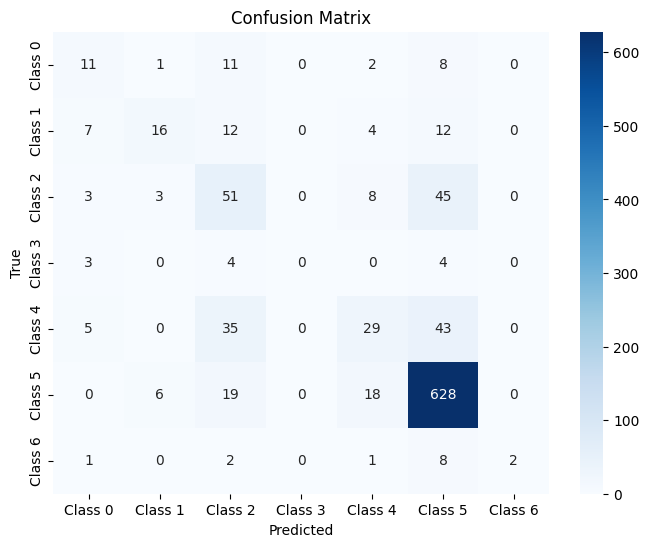

 ROC-AUC (macro): 0.9024


In [20]:
from sklearn.metrics import classification_report  
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
def metrics():
    # Evaluate model on test data
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)
    print(f"✅ Test Accuracy: {test_acc:.4f}")
    print(f"✅ Test Loss: {test_loss:.4f}")
    
    y_pred_probs = model.predict(X_test)             # probabilities (N, 7)
    y_pred = np.argmax(y_pred_probs, axis=1)  
    

    print("\n📊 Classification Report:")
    print(classification_report(y_test, y_pred, digits=4)) 
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=[f"Class {i}" for i in range(7)],
                yticklabels=[f"Class {i}" for i in range(7)])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()
    # Binarize test labels (one-hot for ROC)
    y_test_bin = label_binarize(y_test, classes=np.arange(7))

    # ROC-AUC (macro average)
    roc_auc = roc_auc_score(y_test_bin, y_pred_probs, multi_class="ovr")
    print(f" ROC-AUC (macro): {roc_auc:.4f}")
    
metrics()

In [ ]:
def save_model(model, model_name="dual_cnn_classifier"):
    model_dir = "/content/drive/MyDrive/mini_proj_data/saved_models/"
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)
    model_path = os.path.join(model_dir, model_name + ".h5")
    model.save(model_path)
    print(f"Model saved to {model_path}")



# 2. Processed images with data splitting outside

In [ ]:
from sklearn.model_selection import train_test_split

# Step 1: Split paths and labels first
paths = df['clean_path'].values
labels = df['label'].values

# 70% train, 30% temp
paths_train, paths_temp, labels_train, labels_temp = train_test_split(
    paths, labels, test_size=0.3, random_state=42, stratify=labels
)
# 20% test, 10% val from temp
paths_test, paths_val, labels_test, labels_val = train_test_split(
    paths_temp, labels_temp, test_size=1/3, random_state=42, stratify=labels_temp
)

# Step 2: Preprocess images for each split
X_train_images = np.array([load_and_preprocess_image(p) for p in paths_train])
X_test_images = np.array([load_and_preprocess_image(p) for p in paths_test])
X_val_images = np.array([load_and_preprocess_image(p) for p in paths_val])

# Step 3: Feature extraction for each split
features_cnn1_train = CNN1.predict(X_train_images, verbose=1)
features_cnn2_train = CNN2.predict(X_train_images, verbose=1)
# ... repeat for test and val sets

# Step 4: Dimensionality reduction, merging, deduplication for each split
# (Apply PCA/FA on train, transform test/val using fitted models)

# Step 5: Train classifier on train set, evaluate on test and val sets
# (Use metrics like accuracy, confusion matrix, etc.)

In [ ]:
# Step 4: Dimensionality reduction, merging, deduplication for each split

from sklearn.decomposition import PCA, FactorAnalysis

# Fit PCA and FA on train set only
pca = PCA(n_components=50, random_state=42)
fa = FactorAnalysis(n_components=50, random_state=42)

# Extract features for all CNNs and splits
features_cnn1_train = CNN1.predict(X_train_images, verbose=1)
features_cnn2_train = CNN2.predict(X_train_images, verbose=1)
features_cnn3_train = CNN3.predict(X_train_images, verbose=1)
features_cnn4_train = CNN4.predict(X_train_images, verbose=1)

features_cnn1_test = CNN1.predict(X_test_images, verbose=1)
features_cnn2_test = CNN2.predict(X_test_images, verbose=1)
features_cnn3_test = CNN3.predict(X_test_images, verbose=1)
features_cnn4_test = CNN4.predict(X_test_images, verbose=1)

features_cnn1_val = CNN1.predict(X_val_images, verbose=1)
features_cnn2_val = CNN2.predict(X_val_images, verbose=1)
features_cnn3_val = CNN3.predict(X_val_images, verbose=1)
features_cnn4_val = CNN4.predict(X_val_images, verbose=1)

# Dual-1: PCA on CNN1+CNN2
all_features_train_dual1 = np.concatenate([features_cnn1_train, features_cnn2_train], axis=1)
features_pca_train = pca.fit_transform(all_features_train_dual1)

all_features_test_dual1 = np.concatenate([features_cnn1_test, features_cnn2_test], axis=1)
features_pca_test = pca.transform(all_features_test_dual1)

all_features_val_dual1 = np.concatenate([features_cnn1_val, features_cnn2_val], axis=1)
features_pca_val = pca.transform(all_features_val_dual1)

# Dual-2: FA on CNN3+CNN4
all_features_train_dual2 = np.concatenate([features_cnn3_train, features_cnn4_train], axis=1)
features_fa_train = fa.fit_transform(all_features_train_dual2)

all_features_test_dual2 = np.concatenate([features_cnn3_test, features_cnn4_test], axis=1)
features_fa_test = fa.transform(all_features_test_dual2)

all_features_val_dual2 = np.concatenate([features_cnn3_val, features_cnn4_val], axis=1)
features_fa_val = fa.transform(all_features_val_dual2)

# Merge features
merged_train = np.concatenate([features_pca_train, features_fa_train], axis=1)
merged_test = np.concatenate([features_pca_test, features_fa_test], axis=1)
merged_val = np.concatenate([features_pca_val, features_fa_val], axis=1)

# Remove duplicate columns
import pandas as pd
merged_train_df = pd.DataFrame(merged_train)
merged_test_df = pd.DataFrame(merged_test)
merged_val_df = pd.DataFrame(merged_val)

# Use train columns to remove duplicates
unique_cols = ~merged_train_df.T.duplicated()
merged_train_df = merged_train_df.loc[:, unique_cols]
merged_test_df = merged_test_df.loc[:, unique_cols]
merged_val_df = merged_val_df.loc[:, unique_cols]

In [ ]:
# Step 5: Train classifier and evaluate metrics

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential([
    Dense(256, activation='relu', input_shape=(merged_train_df.shape[1],)),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(7, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    merged_train_df.values, labels_train,
    validation_data=(merged_val_df.values, labels_val),
    epochs=80,
    batch_size=128,
    callbacks=[early_stop],
    verbose=1
)

# Evaluate on test set
test_loss, test_acc = model.evaluate(merged_test_df.values, labels_test, verbose=1)
print(f"✅ Test Accuracy: {test_acc:.4f}")
print(f"✅ Test Loss: {test_loss:.4f}")

# Classification report and confusion matrix
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred_probs = model.predict(merged_test_df.values)
y_pred = np.argmax(y_pred_probs, axis=1)

print("\n📊 Classification Report:")
print(classification_report(labels_test, y_pred, digits=4))
cm = confusion_matrix(labels_test, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=[f"Class {i}" for i in range(7)],
            yticklabels=[f"Class {i}" for i in range(7)])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# 2. Un processed images

# 3. Unprocessed images with train-test outside arch

In [ ]:
from sklearn.model_selection import train_test_split

# Step 1: Split paths and labels first
paths = df['clean_path'].values
labels = df['label'].values

# 70% train, 30% temp
paths_train, paths_temp, labels_train, labels_temp = train_test_split(
    paths, labels, test_size=0.3, random_state=42, stratify=labels
)
# 20% test, 10% val from temp
paths_test, paths_val, labels_test, labels_val = train_test_split(
    paths_temp, labels_temp, test_size=1/3, random_state=42, stratify=labels_temp
)

# Step 2: Preprocess images for each split
X_train_images = np.array([load_and_preprocess_image(p) for p in paths_train])
X_test_images = np.array([load_and_preprocess_image(p) for p in paths_test])
X_val_images = np.array([load_and_preprocess_image(p) for p in paths_val])

# Step 3: Feature extraction for each split
features_cnn1_train = CNN1.predict(X_train_images, verbose=1)
features_cnn2_train = CNN2.predict(X_train_images, verbose=1)
# ... repeat for test and val sets

# Step 4: Dimensionality reduction, merging, deduplication for each split
# (Apply PCA/FA on train, transform test/val using fitted models)

# Step 5: Train classifier on train set, evaluate on test and val sets
# (Use metrics like accuracy, confusion matrix, etc.)

In [ ]:
# Step 4: Dimensionality reduction, merging, deduplication for each split

from sklearn.decomposition import PCA, FactorAnalysis

# Fit PCA and FA on train set only
pca = PCA(n_components=50, random_state=42)
fa = FactorAnalysis(n_components=50, random_state=42)

# Extract features for all CNNs and splits
features_cnn1_train = CNN1.predict(X_train_images, verbose=1)
features_cnn2_train = CNN2.predict(X_train_images, verbose=1)
features_cnn3_train = CNN3.predict(X_train_images, verbose=1)
features_cnn4_train = CNN4.predict(X_train_images, verbose=1)

features_cnn1_test = CNN1.predict(X_test_images, verbose=1)
features_cnn2_test = CNN2.predict(X_test_images, verbose=1)
features_cnn3_test = CNN3.predict(X_test_images, verbose=1)
features_cnn4_test = CNN4.predict(X_test_images, verbose=1)

features_cnn1_val = CNN1.predict(X_val_images, verbose=1)
features_cnn2_val = CNN2.predict(X_val_images, verbose=1)
features_cnn3_val = CNN3.predict(X_val_images, verbose=1)
features_cnn4_val = CNN4.predict(X_val_images, verbose=1)

# Dual-1: PCA on CNN1+CNN2
all_features_train_dual1 = np.concatenate([features_cnn1_train, features_cnn2_train], axis=1)
features_pca_train = pca.fit_transform(all_features_train_dual1)

all_features_test_dual1 = np.concatenate([features_cnn1_test, features_cnn2_test], axis=1)
features_pca_test = pca.transform(all_features_test_dual1)

all_features_val_dual1 = np.concatenate([features_cnn1_val, features_cnn2_val], axis=1)
features_pca_val = pca.transform(all_features_val_dual1)

# Dual-2: FA on CNN3+CNN4
all_features_train_dual2 = np.concatenate([features_cnn3_train, features_cnn4_train], axis=1)
features_fa_train = fa.fit_transform(all_features_train_dual2)

all_features_test_dual2 = np.concatenate([features_cnn3_test, features_cnn4_test], axis=1)
features_fa_test = fa.transform(all_features_test_dual2)

all_features_val_dual2 = np.concatenate([features_cnn3_val, features_cnn4_val], axis=1)
features_fa_val = fa.transform(all_features_val_dual2)

# Merge features
merged_train = np.concatenate([features_pca_train, features_fa_train], axis=1)
merged_test = np.concatenate([features_pca_test, features_fa_test], axis=1)
merged_val = np.concatenate([features_pca_val, features_fa_val], axis=1)

# Remove duplicate columns
import pandas as pd
merged_train_df = pd.DataFrame(merged_train)
merged_test_df = pd.DataFrame(merged_test)
merged_val_df = pd.DataFrame(merged_val)

# Use train columns to remove duplicates
unique_cols = ~merged_train_df.T.duplicated()
merged_train_df = merged_train_df.loc[:, unique_cols]
merged_test_df = merged_test_df.loc[:, unique_cols]
merged_val_df = merged_val_df.loc[:, unique_cols]

In [ ]:
# Step 5: Train classifier and evaluate metrics

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential([
    Dense(256, activation='relu', input_shape=(merged_train_df.shape[1],)),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(7, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    merged_train_df.values, labels_train,
    validation_data=(merged_val_df.values, labels_val),
    epochs=80,
    batch_size=128,
    callbacks=[early_stop],
    verbose=1
)

# Evaluate on test set
test_loss, test_acc = model.evaluate(merged_test_df.values, labels_test, verbose=1)
print(f"✅ Test Accuracy: {test_acc:.4f}")
print(f"✅ Test Loss: {test_loss:.4f}")

# Classification report and confusion matrix
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred_probs = model.predict(merged_test_df.values)
y_pred = np.argmax(y_pred_probs, axis=1)

print("\n📊 Classification Report:")
print(classification_report(labels_test, y_pred, digits=4))
cm = confusion_matrix(labels_test, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=[f"Class {i}" for i in range(7)],
            yticklabels=[f"Class {i}" for i in range(7)])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()